This function should enable us to import image data from the IR VIVO in CILS at Northeastern University. It should require the directory path and experiment title to be inputted. Confirm also that the parameter combinations are correct (these may change, but rarely, so data collected in various eras should all be consistent with the same excitation and emission designations). Details should be read in from the metadata included with the original hdf5 file.

In [44]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [45]:
def import_h5(directory, experiment_title):

    laser_wavelengths = {'1': '670', '2': '760', '3': '808'}
    emission_filters = {'12': 'BP1150', '13': 'BP1200', '14': 'BP1250', '15': 'BP1300', '16': 'BP1350', '17': 'BP1575'}

    # Get the list of darkcount files
    darkcount_files = [f for f in os.listdir(directory) if f.startswith('darkcounts')]
    darkcount_files.sort(key=lambda x: float(x[10:-3]))

    # Initialize a dictionary to store the image file lists
    image_files = {}

    # Get the list of image files for each parameter combination
    for laser_key, laser_value in laser_wavelengths.items():
        for filter_key, filter_value in emission_filters.items():
            key = f"{experiment_title}_{laser_value}_{filter_value}"
            image_files[key] = [f for f in os.listdir(directory) if f.startswith(f"{experiment_title}_{laser_key}_{filter_key}")]
            image_files[key].sort(key=lambda x: float(x.split('_')[-1][:-3]))

    # Read the darkcount files and store the data
    darkcount_data = []
    exposure_times = []
    for file in darkcount_files:
        file_path = os.path.join(directory, file)
        with h5py.File(file_path, 'r') as h5f:
            darkcount = h5f['Cube']['Images'][()]
            exposure_time = h5f['Cube']['TimeExposure'][()].item()
            darkcount_data.append(darkcount)
            exposure_times.append(exposure_time)

    # Concatenate the darkcount data into an array with dimensions (num_exposure_times, height, width)
    darkcount_array = np.squeeze(np.array(darkcount_data))

    # Convert exposure_times to a NumPy array
    exposure_times = np.array(exposure_times)

    # Read the image files and store the data for each parameter combination
    image_arrays = {}
    for key, files in image_files.items():
        image_data = []
        for file in files:
            file_path = os.path.join(directory, file)
            with h5py.File(file_path, 'r') as h5f:
                image = h5f['Cube']['Images'][()]
                image_data.append(image)
        image_arrays[key] = np.squeeze(np.array(image_data))

    # remove noise/darkcounts
    # Calculate the mean and standard deviation of pixel intensities for each exposure time in the darkcount cube
    darkcount_mean = np.mean(darkcount_array[:, :, :], axis=(1, 2))
    darkcount_std = np.std(darkcount_array[:, :, :], axis=(1, 2))
    print("Average darkcount value:", darkcount_mean)
    print("Darkcount standard deviation:", darkcount_std)

    # Define the threshold multiplier (e.g., 2 for mean + 2*std)
    threshold_multiplier = 0

    # Create a dictionary to store the denoised image arrays
    image_denoised_arrays = {}

    # Zero out pixels below the threshold in each image cube
    for key in image_arrays.keys():
        threshold = darkcount_mean + threshold_multiplier * darkcount_std
        denoised_array = np.where(image_arrays[key] > threshold[:, np.newaxis, np.newaxis], image_arrays[key] - threshold[:, np.newaxis, np.newaxis], 0)
        image_denoised_arrays[key] = denoised_array

    print("Threshold:", threshold)
    print("Denoised arrays:", image_denoised_arrays[key])
   
    # NOTE: removed code lines to convert image_arrays and image_denoised_arrays into numpy arrays (I think they already are)
    # replace this if they are in fact needed

    # Print the shapes of the arrays
    print("Darkcount array shape:", darkcount_array.shape)
    print("Exposure times array shape:", exposure_times.shape)
    print(exposure_times)
    for key in image_arrays.keys():
        print(f"Image array shape for {key}:", image_arrays[key].shape)


    return {
        "images": image_arrays,
        "exposure_times": exposure_times,
        "darkcount_images": darkcount_array,
        "denoised_images": image_denoised_arrays
    }

In [47]:
# Enter the directory path and experiment title
directory = '/Users/allisondennis/Library/CloudStorage/OneDrive-NortheasternUniversity/AMD/IR VIVO data/240330_frozen_RO_supine_macro/'
experiment_title = 'frozen_RO_supine_macro'

# Import the experimental files from that directory with that experiment title; 
# extract imaging parameters (excitation wavelength, emission filter, and exposure time) from file metadata;
# use the metadeta to label the arrays experimentname_excitationlaser_BPfilter.
# assume directory includes darkcount data. Output the dictionary containing the array of images, the array of exposure times
# the array of darkcount images, and the dictionary of darkcount subtracted (denoised) images.
extracted_images = import_h5(directory, experiment_title)
image_arrays = extracted_images['images']
exposure_times = extracted_images['exposure_times']
darkcount_array = extracted_images['darkcount_images']
image_denoised_arrays = extracted_images['denoised_images']


Average darkcount value: [ 800.26126709  964.50210876 1061.47077637 1090.32785339 1106.2705658
 1123.00350037 1138.0115387  1151.49855347 1167.88835449 1183.28447876
 1202.85941467 1229.39541931 1266.1712738  1329.5353241  1444.72843323]
Darkcount standard deviation: [12.89242677 13.12867421 13.34699424 13.57551482 13.62781661 13.70648465
 13.68587446 13.55620008 13.34926993 13.17422195 13.29244113 13.88850629
 14.78012171 16.01021718 17.73978176]
Threshold: [ 800.26126709  964.50210876 1061.47077637 1090.32785339 1106.2705658
 1123.00350037 1138.0115387  1151.49855347 1167.88835449 1183.28447876
 1202.85941467 1229.39541931 1266.1712738  1329.5353241  1444.72843323]
Denoised arrays: [[[ 0.          0.73873291  0.         ... 18.73873291 17.73873291
   17.73873291]
  [ 2.73873291  8.73873291  5.73873291 ...  0.          5.73873291
    0.73873291]
  [ 0.          9.73873291 24.73873291 ...  7.73873291  0.
    0.        ]
  ...
  [ 6.73873291 13.73873291 17.73873291 ...  0.          0.
 

In [52]:
def plot_image_array(image_set):
    "Plot a tight arrangement of the full series of exposure times for each imaging condition on the same intensity scale"
    # Extract the minimum and maximum intensity values for each image array
    min_max_dict = {}
    for key in image_set.keys():
        min_val = np.min(image_set[key])
        max_val = np.max(image_set[key])
        min_max_dict[key] = (min_val, max_val)

    # Print the minimum and maximum intensity values for each image array
    for key, (min_val, max_val) in min_max_dict.items():
        print(f"Intensity range for {key}: Min = {min_val}, Max = {max_val}")

    # Plot the image arrays using the same intensity scale
    for key, array in image_set.items():
        fig, axes = plt.subplots(1, array.shape[0], figsize=(15, 2))
        fig.suptitle(key)
    
        min_val, max_val = min_max_dict[key]
    
        for i in range(array.shape[0]):
            ax = axes[i]
            ax.imshow(array[i, :, :], cmap='gray', vmin=min_val, vmax=max_val)
            ax.set_title(f'{exposure_times[i]} s')
            ax.axis('off')
    
        plt.tight_layout()
        plt.show()

Intensity range for frozen_RO_supine_macro_670_BP1150: Min = 705, Max = 4763
Intensity range for frozen_RO_supine_macro_670_BP1200: Min = 692, Max = 4789
Intensity range for frozen_RO_supine_macro_670_BP1250: Min = 702, Max = 4824
Intensity range for frozen_RO_supine_macro_670_BP1300: Min = 704, Max = 4848
Intensity range for frozen_RO_supine_macro_670_BP1350: Min = 694, Max = 4792
Intensity range for frozen_RO_supine_macro_670_BP1575: Min = 698, Max = 4374
Intensity range for frozen_RO_supine_macro_760_BP1150: Min = 705, Max = 4840
Intensity range for frozen_RO_supine_macro_760_BP1200: Min = 667, Max = 4836
Intensity range for frozen_RO_supine_macro_760_BP1250: Min = 682, Max = 4893
Intensity range for frozen_RO_supine_macro_760_BP1300: Min = 677, Max = 4906
Intensity range for frozen_RO_supine_macro_760_BP1350: Min = 695, Max = 4863
Intensity range for frozen_RO_supine_macro_760_BP1575: Min = 682, Max = 4349
Intensity range for frozen_RO_supine_macro_808_BP1150: Min = 679, Max = 4747

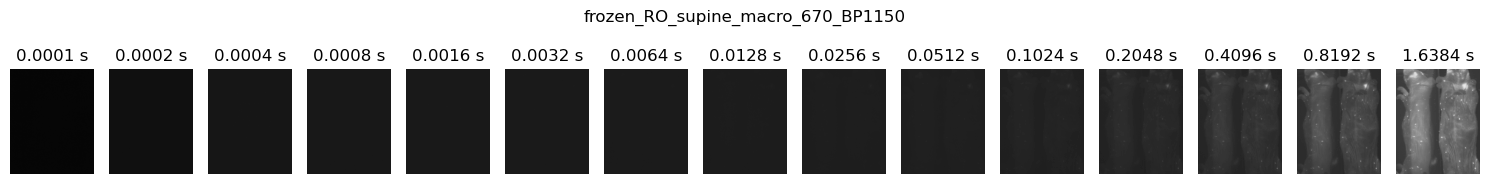

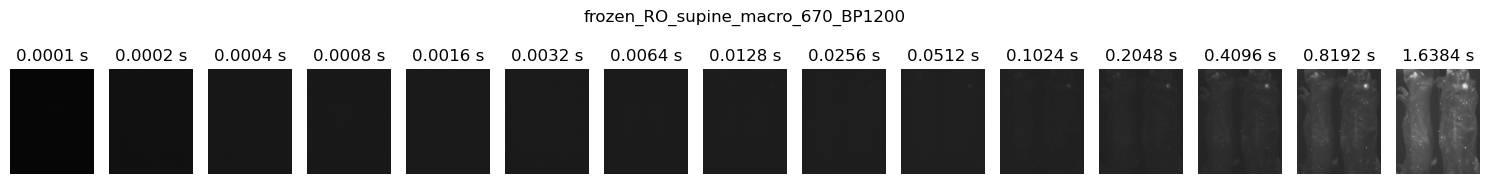

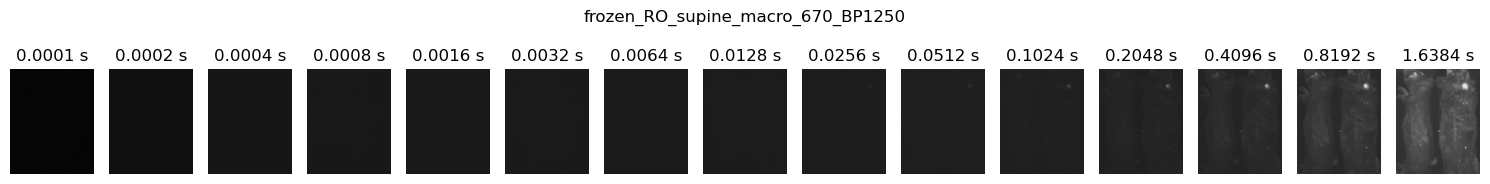

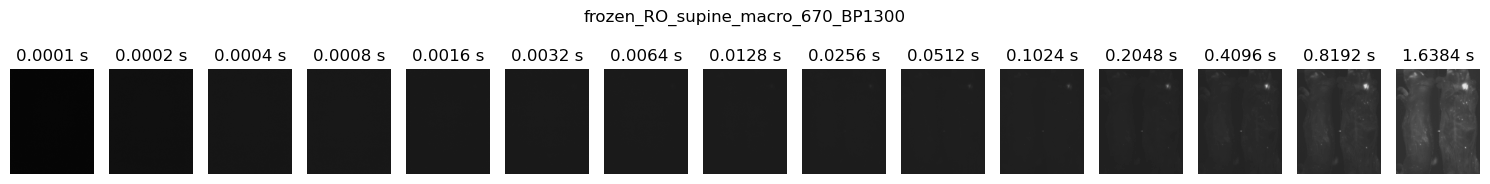

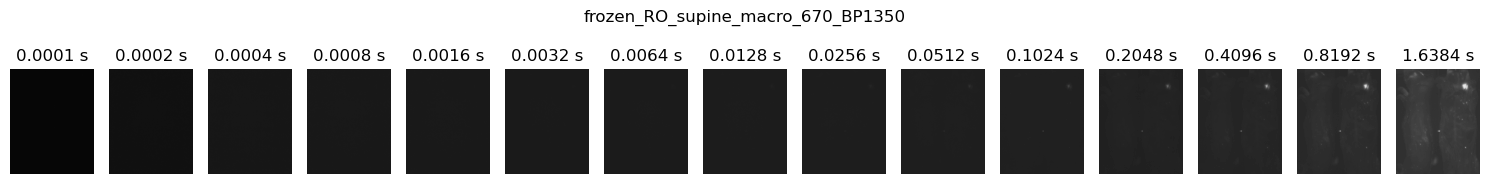

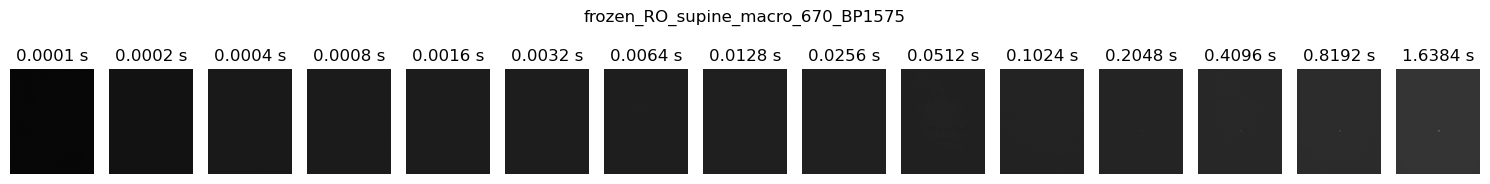

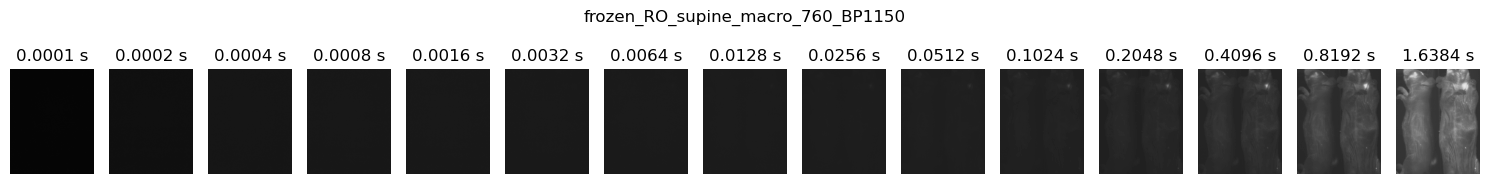

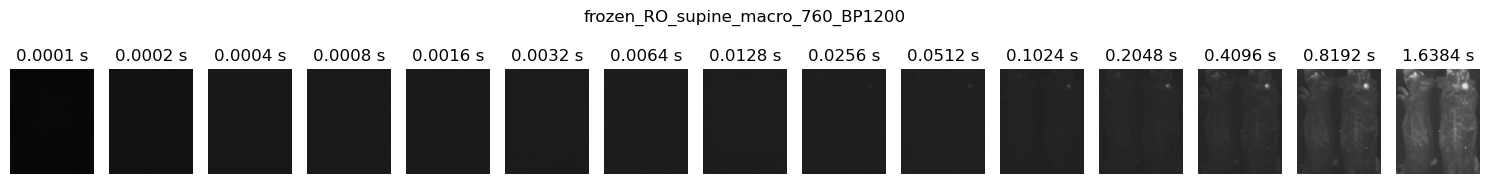

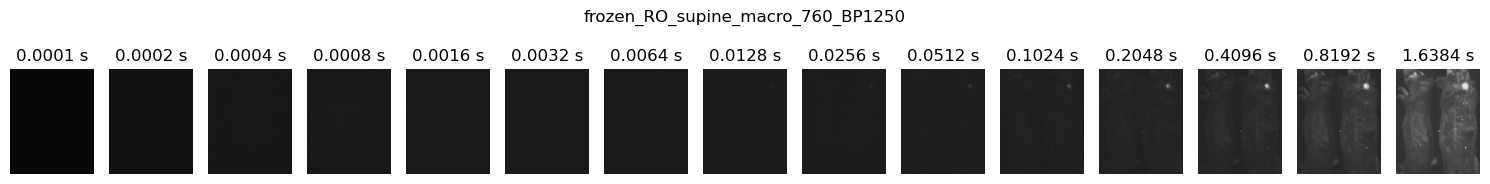

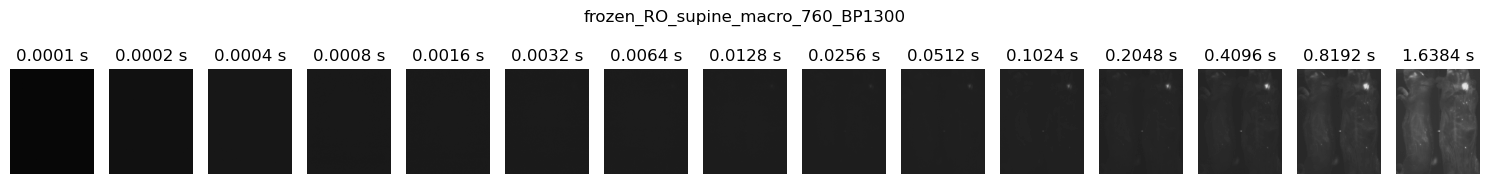

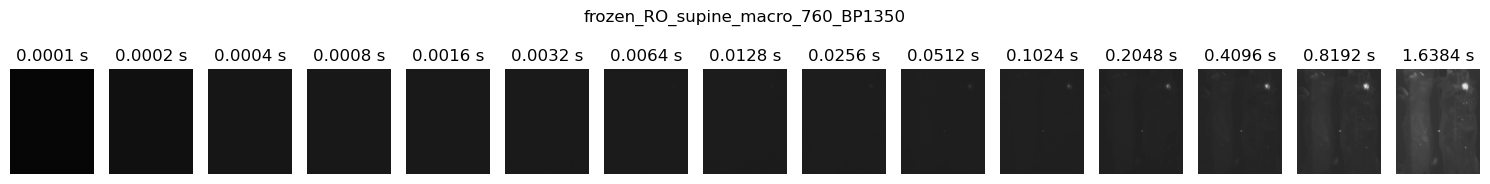

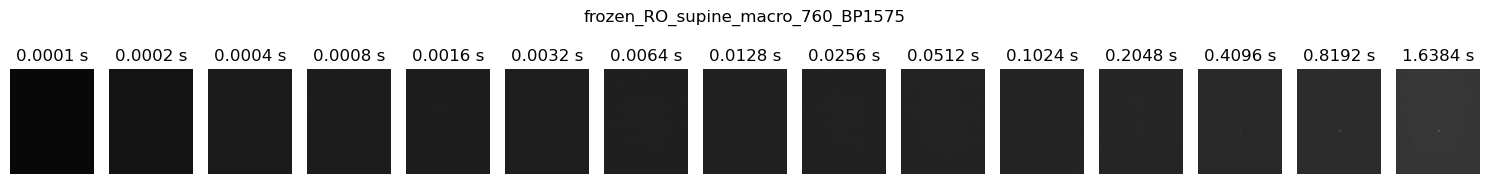

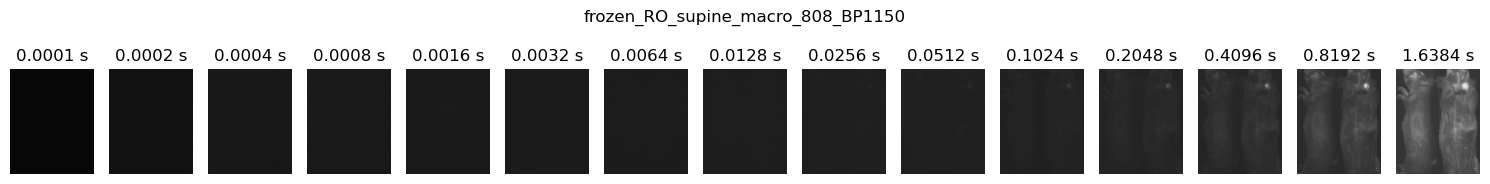

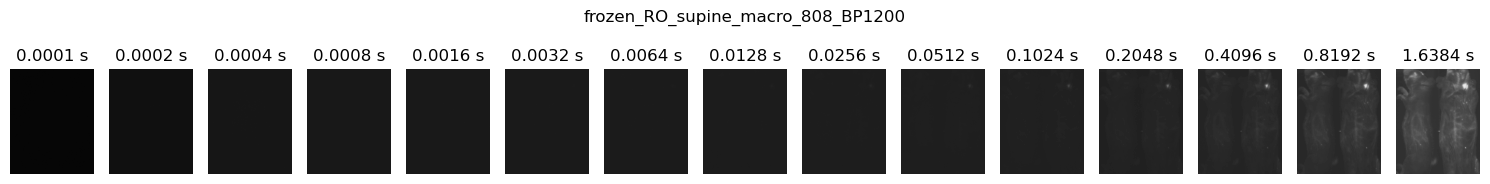

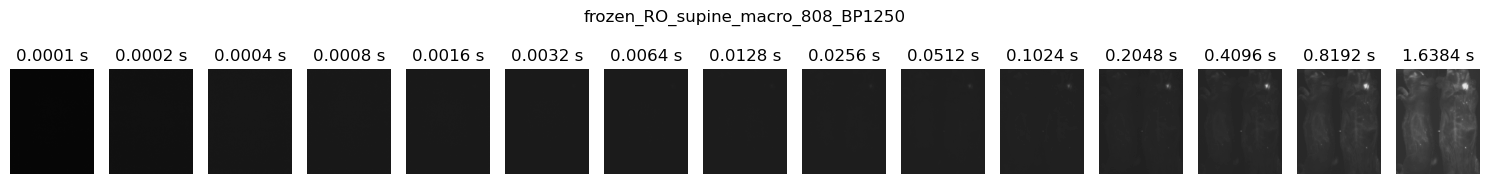

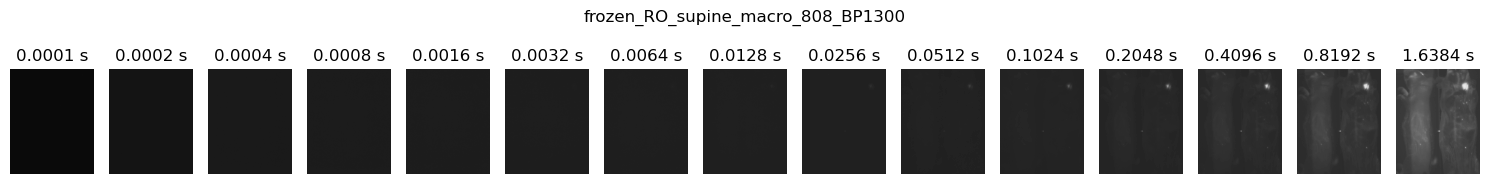

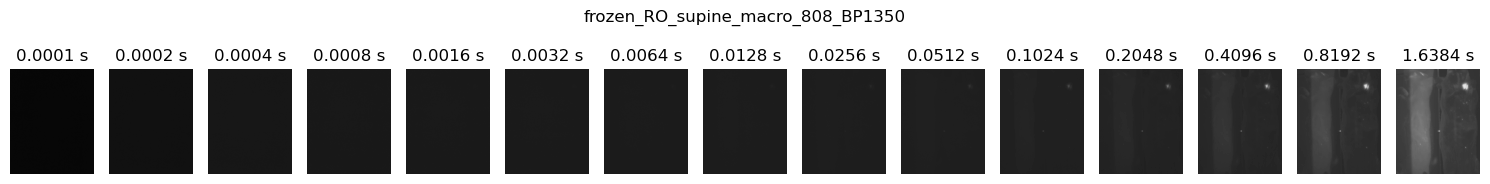

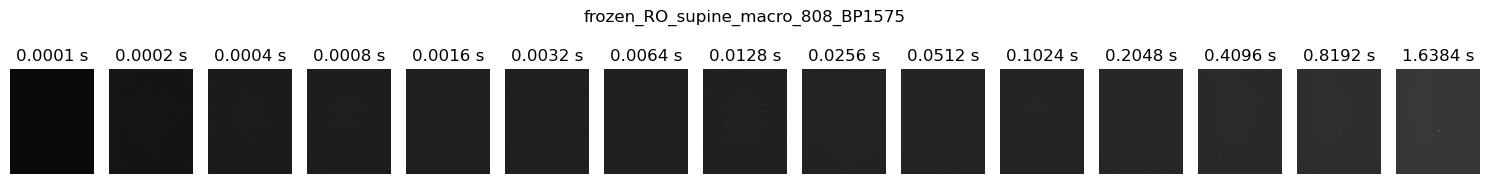

In [53]:
plot_image_array(image_set=image_arrays)

Intensity range for frozen_RO_supine_macro_670_BP1150: Min = 0.0, Max = 3336.4646759033203
Intensity range for frozen_RO_supine_macro_670_BP1200: Min = 0.0, Max = 3344.271566772461
Intensity range for frozen_RO_supine_macro_670_BP1250: Min = 0.0, Max = 3379.271566772461
Intensity range for frozen_RO_supine_macro_670_BP1300: Min = 0.0, Max = 3411.828726196289
Intensity range for frozen_RO_supine_macro_670_BP1350: Min = 0.0, Max = 3386.828726196289
Intensity range for frozen_RO_supine_macro_670_BP1575: Min = 0.0, Max = 2929.271566772461
Intensity range for frozen_RO_supine_macro_760_BP1150: Min = 0.0, Max = 3395.271566772461
Intensity range for frozen_RO_supine_macro_760_BP1200: Min = 0.0, Max = 3391.271566772461
Intensity range for frozen_RO_supine_macro_760_BP1250: Min = 0.0, Max = 3448.271566772461
Intensity range for frozen_RO_supine_macro_760_BP1300: Min = 0.0, Max = 3461.271566772461
Intensity range for frozen_RO_supine_macro_760_BP1350: Min = 0.0, Max = 3418.271566772461
Intensity

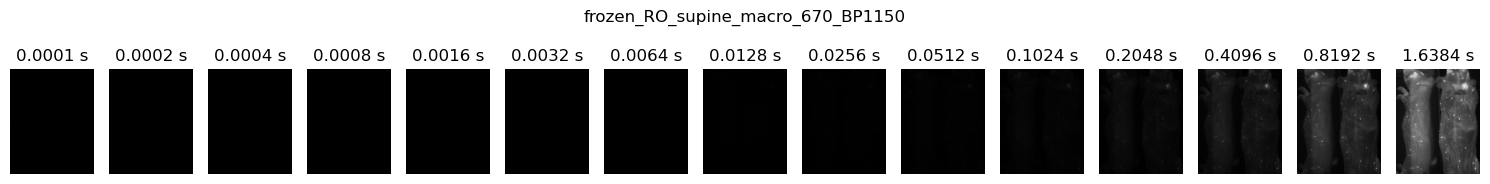

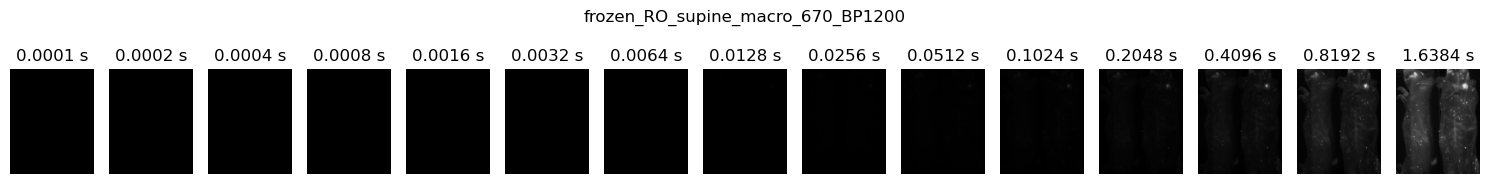

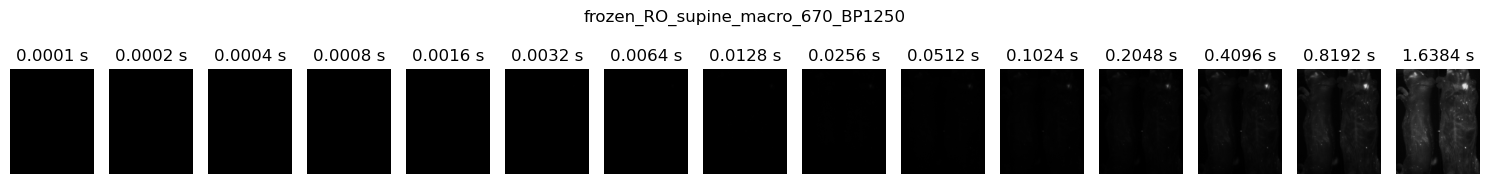

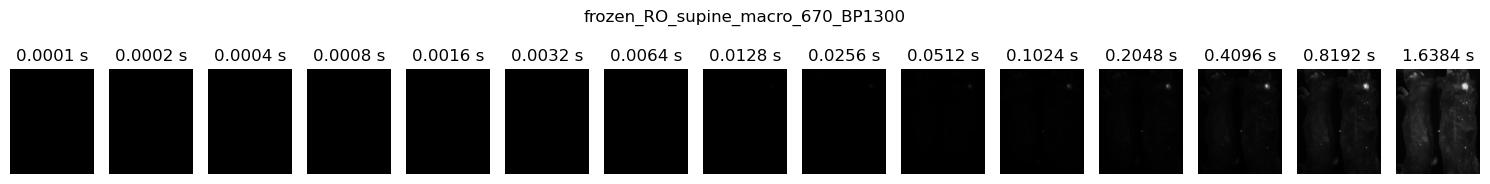

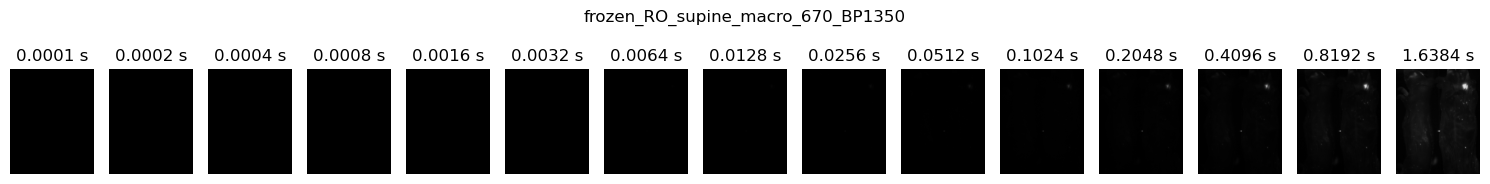

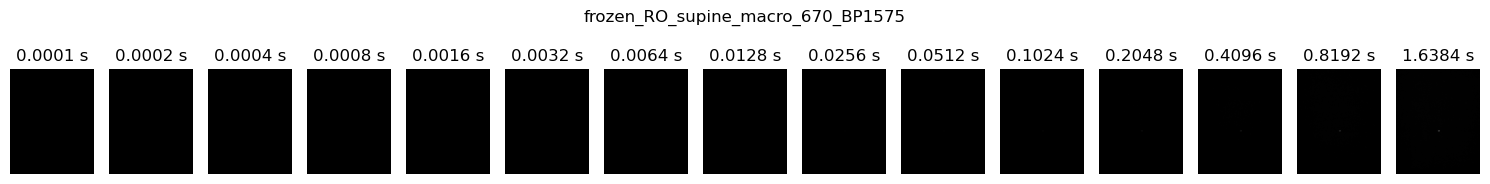

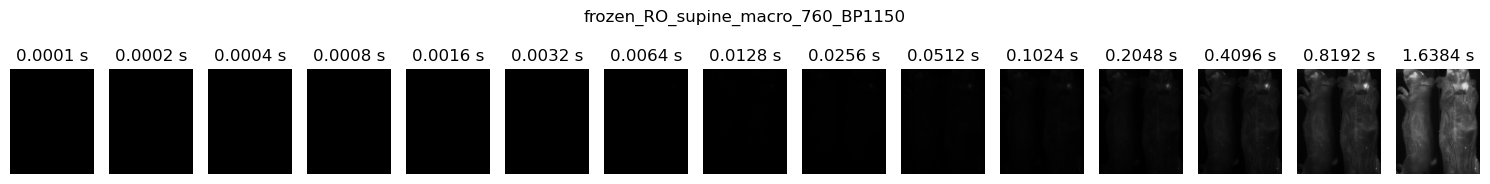

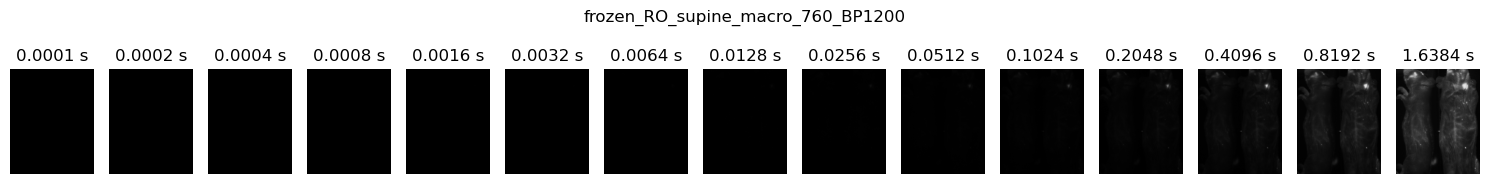

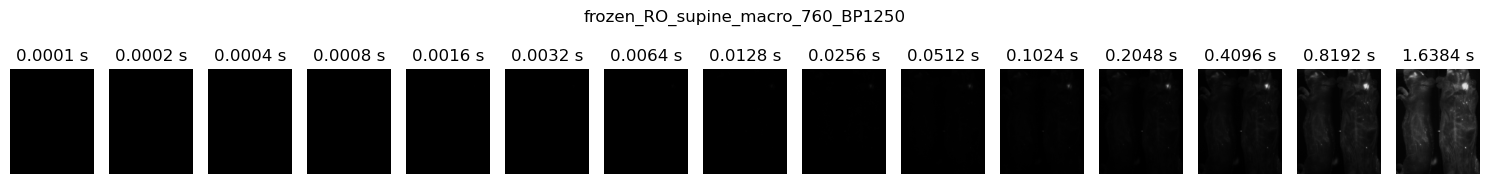

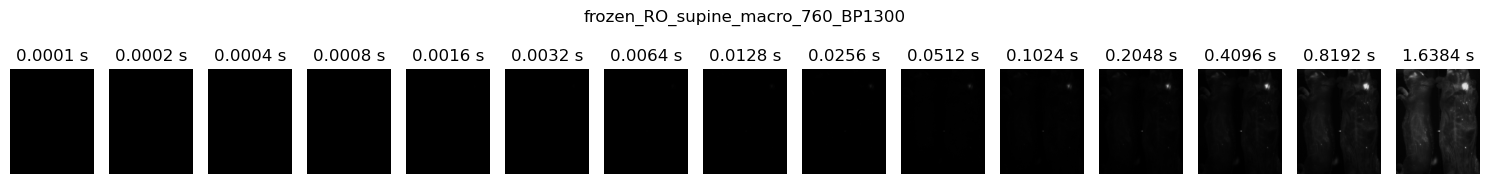

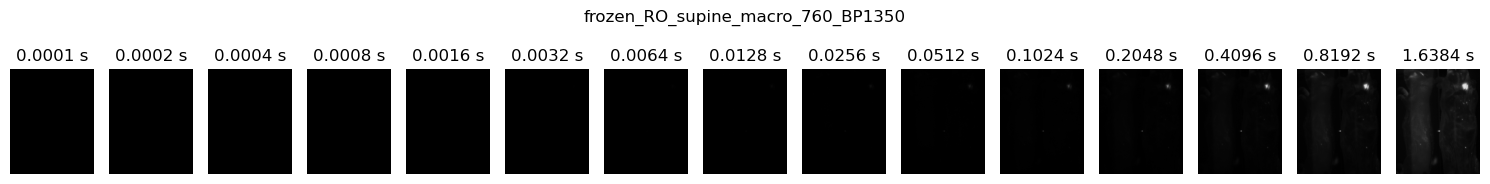

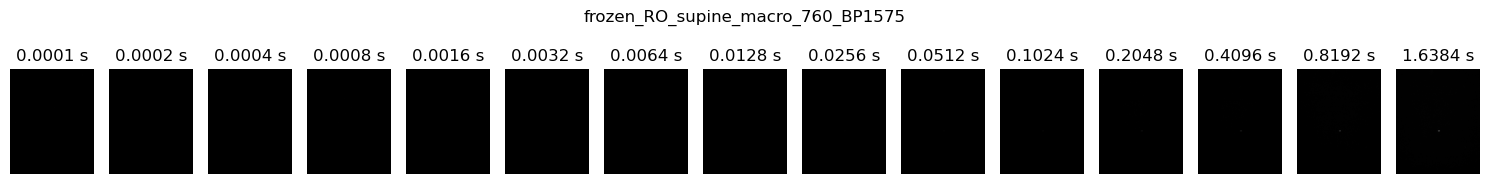

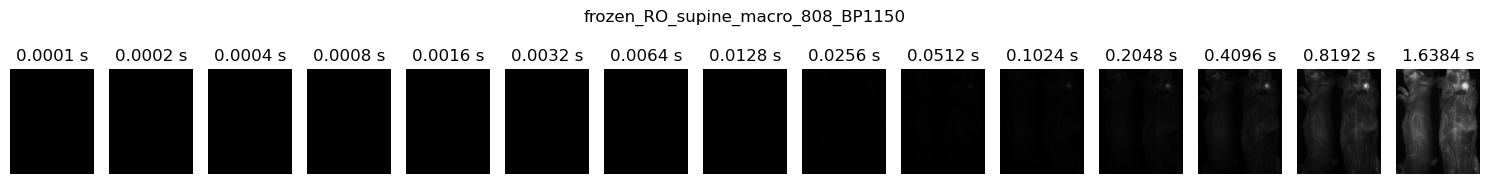

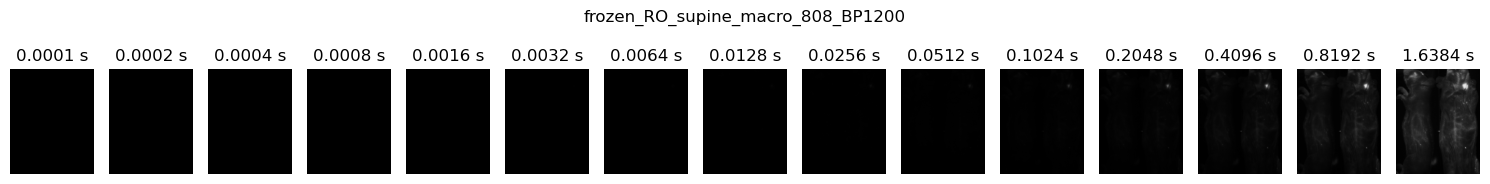

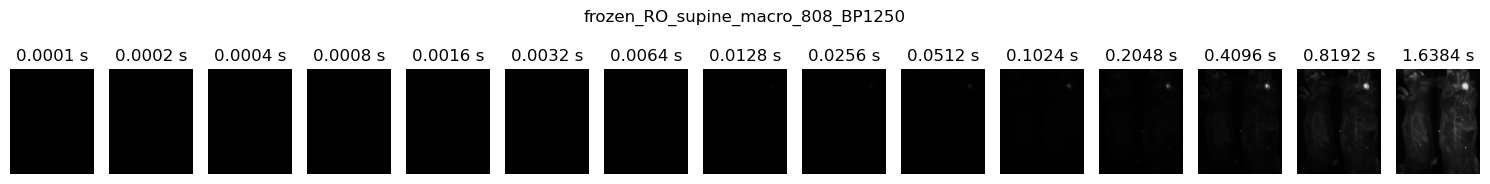

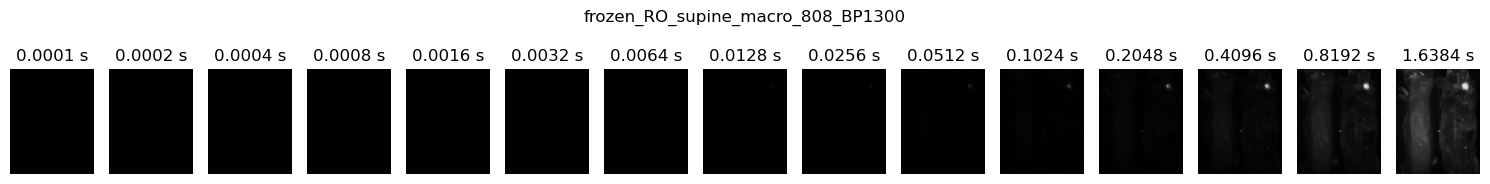

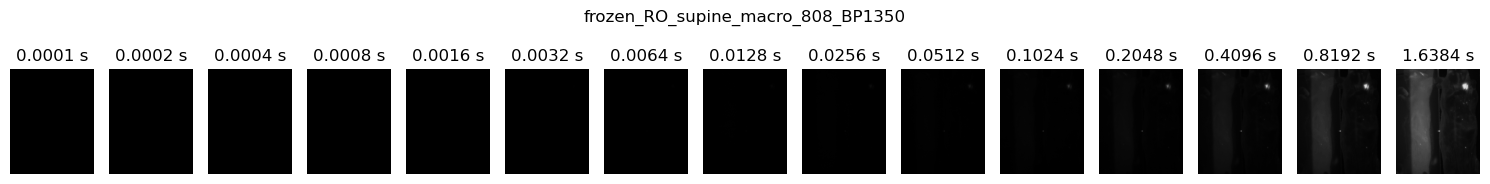

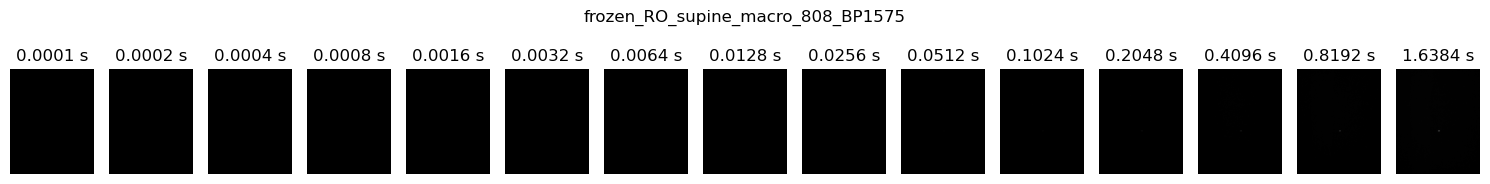

In [51]:
plot_image_array(image_set=image_denoised_arrays)